In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline                                           
from sklearn.preprocessing import StandardScaler                                     
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score as AUC
from sklearn.base import clone
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from multiprocessing import Pool
from sklearn import linear_model
from tqdm import tqdm
from scipy.spatial import distance
from skbio.stats.ordination import pcoa
import umap
%run -i '../../../../../../utils.py'

# Get data

In [8]:
# read meta data
df_meta = pd.read_csv('../../../../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin'] # only for inulin group
df_meta = df_meta[df_meta.Day != 0] # remove day 0

# read SCFA data
df_scfa = pd.read_csv('../../../../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance
df_bac = pd.read_csv('../../../../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# find common samples
common_samples = list(set(df_meta.index).intersection(df_scfa.index).intersection(df_bac.index))
df_meta = df_meta.loc[common_samples]
df_scfa = df_scfa.loc[common_samples]
df_bac = df_bac.loc[common_samples]

# Run covariant shift adaptation

In [15]:
def get_weights(X, Z): # X is test and Z is train
    X.loc[:, "is_z"] = 0
    Z.loc[:, "is_z"] = 1
    XZ = pd.concat([X, Z],ignore_index=True) # keep index
    labels = XZ['is_z'].values
    XZ_mat = XZ.drop('is_z', axis=1).values
     
    # test if X and Z can be distinguished
    clf = RFC(n_estimators=100, max_depth=3,random_state=0)
    predictions = np.zeros(labels.shape)
    skf = SKF(n_splits=20, shuffle=True, random_state=0)
    for fold, (train_idx, test_idx) in enumerate(skf.split(XZ_mat, labels)):
        X_train, X_test = XZ_mat[train_idx,:], XZ_mat[test_idx,:]
        y_train, y_test = labels[train_idx], labels[test_idx]

        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_test)[:, 1] # probability that each data point is a sample from training set
        predictions[test_idx] = probs
    roc_auc = AUC(labels, predictions)
    
    # weight_i = p_i(X|D)/p_i(Z|D)
    predictions_Z = predictions[len(X):] # p(Z/D)
    weights = (1./predictions_Z) - 1. # p(X|D)/p(Z/D)
    weights /= np.mean(weights) # we do this to re-normalize the computed log-loss
    XZ['size'] = 4
    XZ.iloc[len(X):, XZ.columns.get_loc('size')] = 0.1 + weights*15
    
    # sort index
    XZ = XZ.sort_index()
    XZ_mat = XZ.drop(['is_z','size'], axis=1).values
    
    # get PCoA
    dist_relab = distance.squareform(distance.pdist(XZ_mat, metric="braycurtis"))
    OrdinationResults = pcoa(dist_relab, number_of_dimensions=2)
    df_ord = pd.DataFrame(OrdinationResults.samples.values, index=XZ.index, columns=['PC1','PC2'])
    
#    # get UMAP
#     fit = umap.UMAP(random_state=0)
#     u = fit.fit_transform(XZ_mat)
#     df_ord = pd.DataFrame(u, index=XZ.index, columns=['PC1','PC2'])

    df_ord['is_z'] = XZ['is_z']
    df_ord['size'] = XZ['size']
    return roc_auc, weights, df_ord

In [16]:
df_res = pd.read_csv('../species_only/param_grid_search_rf_oob.csv', index_col=0)
df_res.head()

,scfa,n_features_to_select,n_trees,max_features,max_depth,min_samples_split,min_samples_leaf,oob
0,Acetate,2,1024,auto,2,2,1,0.165086
1,Butyrate,2,1024,auto,2,2,1,0.402696
2,Propionate,2,1024,auto,2,2,1,0.406989
3,Acetate,2,2048,auto,2,2,1,0.167124
4,Butyrate,2,2048,auto,2,2,1,0.400276


## intrapolation

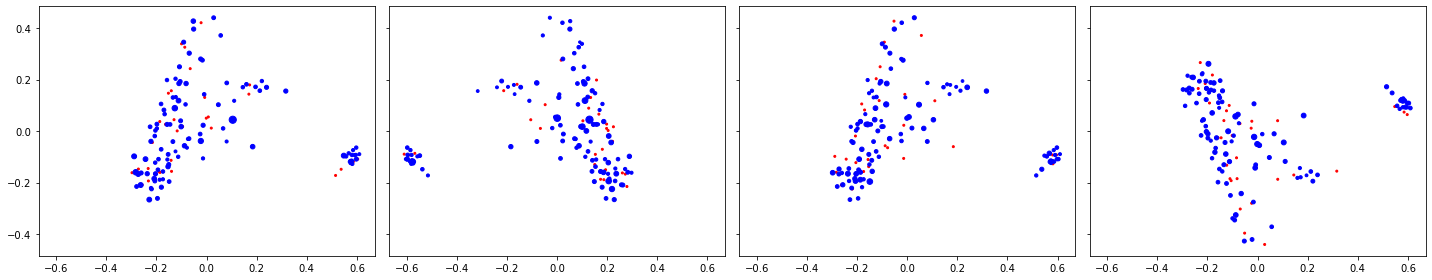

In [21]:
roc_auc_intra = {}
lines = []
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4), sharex=True, sharey=True)

for k,group_to_exclude in enumerate(['A','B','C','D']):

    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.RandomizedGroup!=group_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.RandomizedGroup==group_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    roc_auc_intra[group_to_exclude], wts, df_ord = get_weights(X=xdata_test, Z=xdata_train)
    #print ("ROC-AUC (%s): %2.2f" % (group_to_exclude, roc_auc_intra[group_to_exclude]))
    assert len(xdata_train)==len(wts)
    
    # show weights on train and test
    # _ = sns.scatterplot(x='PC1', y='PC2', hue='is_z', size='size', data=df_ord, ax=ax[k])
    df_ord_0 = df_ord.loc[df_ord.is_z==0]
    _ = ax[k].scatter(df_ord_0['PC1'], df_ord_0['PC2'], marker='o', s=df_ord_0['size'], c='r', label='X')
    df_ord_1 = df_ord.loc[df_ord.is_z==1]
    _ = ax[k].scatter(df_ord_1['PC1'], df_ord_1['PC2'], marker='o', s=df_ord_1['size'], c='b', label='Z')

    xdata_train = np.asarray(xdata_train.values)
    xdata_test = np.asarray(xdata_test.values)
    
    wts=None
    
    # run random forest regression with weights
    for scfa in ['Acetate','Propionate','Butyrate']:                
        ydata_train = np.asarray(df_scfa.loc[samples_to_keep, scfa])
        ydata_test = np.asarray(df_scfa.loc[samples_to_exclude, scfa])

        # make pipeline
        params = df_res[df_res.scfa==scfa].sort_values('oob', ascending=False).iloc[0]
        clf = RandomForestRegressor(n_estimators=params['n_trees'],
                                    max_features=float(params['max_features']) if '.' in params['max_features'] else params['max_features'],
                                    random_state=0, 
                                    oob_score=True, 
                                    max_depth=params['max_depth'],
                                    min_samples_split=params['min_samples_split'],
                                    min_samples_leaf=params['min_samples_leaf']
                                   )
        pipe = make_pipeline(StandardScaler(), SelectFromModel(clf, max_features=params['n_features_to_select'], threshold=-np.inf), clone(clf))  
        pipe.fit(xdata_train, ydata_train, selectfrommodel__sample_weight=wts, randomforestregressor__sample_weight=wts)

        # predict training set
        ydata_train_predicted = pipe.predict(xdata_train)
        ydata_test_predicted = pipe.predict(xdata_test)

        for sample_, obs_, pred_ in zip(samples_to_keep, ydata_train, ydata_train_predicted):
            day_ = df_meta.loc[sample_,'Day']
            lines.append([scfa, group_to_exclude, 'train', sample_, day_, obs_, pred_])
        for sample_, obs_, pred_ in zip(samples_to_exclude, ydata_test, ydata_test_predicted):
            day_ = df_meta.loc[sample_,'Day']
            lines.append([scfa, group_to_exclude, 'test', sample_, day_, obs_, pred_])

df_pred_intra = pd.DataFrame(lines, columns=['SCFA','Permutation','PredictionType','SampleID','Day','ObservedValue','PredictedValue'])
#df_pred_intra.head()

plt.tight_layout()

## extrapolation

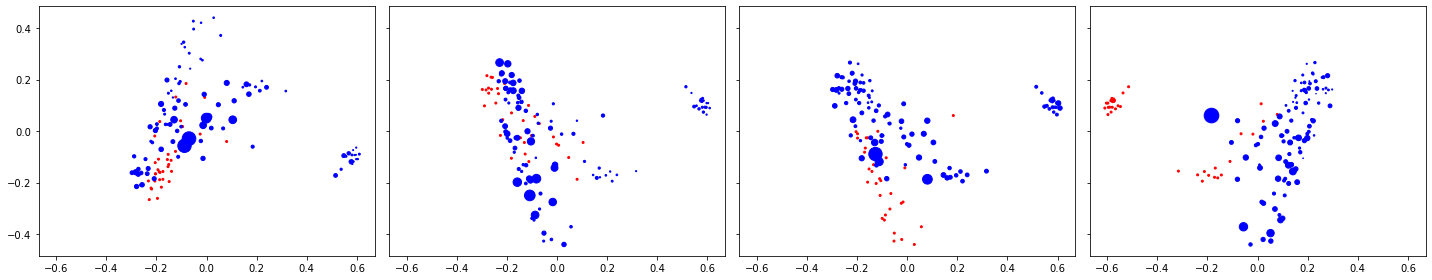

In [24]:
roc_auc_extra = {}
lines = []
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4), sharex=True, sharey=True)

for k,vendor_to_exclude in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        
    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.Vendor!=vendor_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.Vendor==vendor_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    roc_auc_extra[vendor_to_exclude], wts, df_ord = get_weights(X=xdata_test, Z=xdata_train)
    #print ("ROC-AUC (%s): %2.2f" % (vendor_to_exclude, roc_auc_extra[vendor_to_exclude]))
    assert len(xdata_train)==len(wts)
    
    # show weights on train and test
    # _ = sns.scatterplot(x='PC1', y='PC2', hue='is_z', size='size', data=df_ord, ax=ax[k])
    df_ord_0 = df_ord.loc[df_ord.is_z==0]
    _ = ax[k].scatter(df_ord_0['PC1'], df_ord_0['PC2'], marker='o', s=df_ord_0['size'], c='r', label='X')
    df_ord_1 = df_ord.loc[df_ord.is_z==1]
    _ = ax[k].scatter(df_ord_1['PC1'], df_ord_1['PC2'], marker='o', s=df_ord_1['size'], c='b', label='Z')

    xdata_train = np.asarray(xdata_train.values)
    xdata_test = np.asarray(xdata_test.values)
    
    wts=None
    # run random forest regression with weights
    for scfa in ['Acetate','Propionate','Butyrate']:                
        ydata_train = np.asarray(df_scfa.loc[samples_to_keep, scfa])
        ydata_test = np.asarray(df_scfa.loc[samples_to_exclude, scfa])

        # make pipeline
        params = df_res[df_res.scfa==scfa].sort_values('oob', ascending=False).iloc[0]
        clf = RandomForestRegressor(n_estimators=params['n_trees'],
                                    max_features=float(params['max_features']) if '.' in params['max_features'] else params['max_features'],
                                    random_state=0, 
                                    oob_score=True, 
                                    max_depth=params['max_depth'],
                                    min_samples_split=params['min_samples_split'],
                                    min_samples_leaf=params['min_samples_leaf']
                                   )
        pipe = make_pipeline(StandardScaler(), SelectFromModel(clf, max_features=params['n_features_to_select'], threshold=-np.inf), clone(clf))  
        pipe.fit(xdata_train, ydata_train, selectfrommodel__sample_weight=wts, randomforestregressor__sample_weight=wts)

        # predict training set
        ydata_train_predicted = pipe.predict(xdata_train)
        ydata_test_predicted = pipe.predict(xdata_test)

        for sample_, obs_, pred_ in zip(samples_to_keep, ydata_train, ydata_train_predicted):
            day_ = df_meta.loc[sample_,'Day']
            lines.append([scfa, vendor_to_exclude, 'train', sample_, day_, obs_, pred_])
        for sample_, obs_, pred_ in zip(samples_to_exclude, ydata_test, ydata_test_predicted):
            day_ = df_meta.loc[sample_,'Day']
            lines.append([scfa, vendor_to_exclude, 'test', sample_, day_, obs_, pred_])

df_pred_extra = pd.DataFrame(lines, columns=['SCFA','Permutation','PredictionType','SampleID','Day','ObservedValue','PredictedValue'])
#df_pred_extra.head()

plt.tight_layout()

# calculate R2

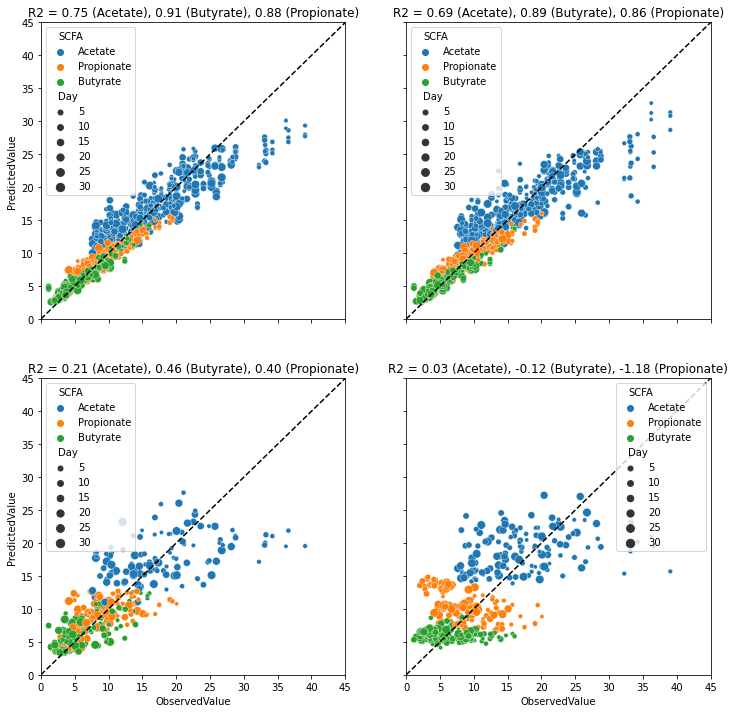

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)

for k,ptype in enumerate(['train','test']):
    # intrapolation
    df_intra_tmp = df_pred_intra[df_pred_intra['PredictionType']==ptype]
    _ = sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_intra_tmp, ax=ax[k,0])
    # extrapolation
    df_extra_tmp = df_pred_extra[df_pred_extra['PredictionType']==ptype]
    _ = sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_extra_tmp, ax=ax[k,1])
    
    # calculate R2
    r2_intra = []
    r2_extra = []
    for scfa in ['Acetate','Butyrate','Propionate']:
        # intrapolation
        df_intra_tmp2 = df_intra_tmp[df_intra_tmp.SCFA==scfa]
        r2_intra.append(r2_score(df_intra_tmp2.ObservedValue, df_intra_tmp2.PredictedValue))
        # extrapolation
        df_extra_tmp2 = df_extra_tmp[df_extra_tmp.SCFA==scfa]
        r2_extra.append(r2_score(df_extra_tmp2.ObservedValue, df_extra_tmp2.PredictedValue))
   
    # add title
    _ = ax[k,0].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2_intra[0], 'Acetate', r2_intra[1], 'Butyrate', r2_intra[2], 'Propionate'))
    _ = ax[k,1].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2_extra[0], 'Acetate', r2_extra[1], 'Butyrate', r2_extra[2], 'Propionate'))
    
    # set xlim and ylim
    _ = ax[0,k].set_xlim([0,45])
    _ = ax[1,k].set_xlim([0,45])
    _ = ax[0,k].set_ylim([0,45])
    _ = ax[1,k].set_ylim([0,45])
    _ = ax[0,k].plot([0,45],[0,45],'k--')
    _ = ax[1,k].plot([0,45],[0,45],'k--')

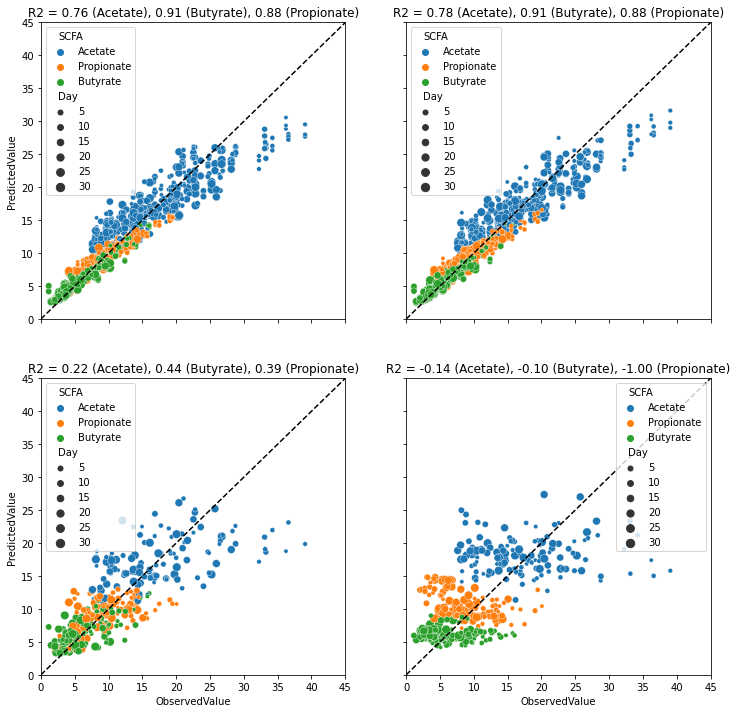

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)

for k,ptype in enumerate(['train','test']):
    # intrapolation
    df_intra_tmp = df_pred_intra[df_pred_intra['PredictionType']==ptype]
    _ = sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_intra_tmp, ax=ax[k,0])
    # extrapolation
    df_extra_tmp = df_pred_extra[df_pred_extra['PredictionType']==ptype]
    _ = sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_extra_tmp, ax=ax[k,1])
    
    # calculate R2
    r2_intra = []
    r2_extra = []
    for scfa in ['Acetate','Butyrate','Propionate']:
        # intrapolation
        df_intra_tmp2 = df_intra_tmp[df_intra_tmp.SCFA==scfa]
        r2_intra.append(r2_score(df_intra_tmp2.ObservedValue, df_intra_tmp2.PredictedValue))
        # extrapolation
        df_extra_tmp2 = df_extra_tmp[df_extra_tmp.SCFA==scfa]
        r2_extra.append(r2_score(df_extra_tmp2.ObservedValue, df_extra_tmp2.PredictedValue))
   
    # add title
    _ = ax[k,0].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2_intra[0], 'Acetate', r2_intra[1], 'Butyrate', r2_intra[2], 'Propionate'))
    _ = ax[k,1].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2_extra[0], 'Acetate', r2_extra[1], 'Butyrate', r2_extra[2], 'Propionate'))
    
    # set xlim and ylim
    _ = ax[0,k].set_xlim([0,45])
    _ = ax[1,k].set_xlim([0,45])
    _ = ax[0,k].set_ylim([0,45])
    _ = ax[1,k].set_ylim([0,45])
    _ = ax[0,k].plot([0,45],[0,45],'k--')
    _ = ax[1,k].plot([0,45],[0,45],'k--')